In [28]:
#%pip install numpy pandas matplotlib scikit-learn tensorflow seaborn folium xgboost

In [29]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [30]:
#df1 = pd.read_csv("../../data/dev101_prepared.csv")
#df2 = pd.read_csv("../../data/dev102_prepared.csv")

#df_all = pd.concat([df1, df2], ignore_index=True)
df_all = pd.read_csv("../../data/devAll2_prepared.csv")

# แปลง timestamp และเรียงลำดับ
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
df_all = df_all.sort_values(by='timestamp').reset_index(drop=True)
df_all

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng,soil_diff,geo_diff
0,2025-05-02 11:42:06.635276,101.0,28.799999,0.0,34.290073,62.429081,14.532875,8.637999,99.899010,6.599998,11.209480
1,2025-05-02 11:42:11.034615,102.0,22.200001,0.0,34.506374,61.542152,14.766250,8.637963,99.898933,-6.599998,0.233375
2,2025-05-02 11:42:18.056572,101.0,28.799999,0.0,34.266041,64.082787,14.673310,8.637998,99.899010,6.599998,-0.092939
3,2025-05-02 11:42:21.675224,102.0,22.200001,0.0,34.485012,61.767223,3.242806,8.637963,99.898933,-6.599998,-11.430505
4,2025-05-02 11:42:28.667259,101.0,28.900000,0.0,34.250019,62.839169,15.995875,8.637998,99.899010,6.699999,12.753070
...,...,...,...,...,...,...,...,...,...,...,...
301185,2025-06-29 20:25:27.980000,101.0,27.900000,0.0,29.101625,81.113754,2.490953,8.638010,99.898972,2.299999,-0.185184
301186,2025-06-29 20:25:48.980000,102.0,25.600000,0.0,29.908064,77.426796,3.856516,8.637931,99.898941,-2.299999,1.365563
301187,2025-06-29 20:26:01.100000,102.0,25.600000,0.0,29.349968,80.005569,2.614293,8.637931,99.898949,0.000000,-1.242223
301188,2025-06-29 20:26:02.150000,101.0,27.900000,0.0,29.050890,81.302589,8.617684,8.638011,99.898972,2.299999,6.003392


In [31]:
print(df_all['devID'].value_counts())

devID
102.0    151583
101.0    149607
Name: count, dtype: int64


In [32]:
# Feature ที่จะใช้
numerical_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng']

# สร้าง Scaler และฟิตข้อมูล
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_all[numerical_cols])

# เพิ่มคอลัมน์ scaled กลับเข้า DataFrame
for i, col in enumerate(numerical_cols):
    df_all[f'scaled_{col}'] = scaled_values[:, i]

# Save scaler (สำหรับใช้งานจริงในอนาคต)
joblib.dump(scaler, 'scaler3.save')


['scaler3.save']

In [33]:
SEQUENCE_LENGTH = 30

def create_sequences_by_device(df, sequence_length, numerical_cols, dev_ids=None, return_index=False):
    """
    สร้าง sequence สำหรับแต่ละ device (devID)
    Args:
        df: DataFrame ที่เตรียมข้อมูลแล้ว
        sequence_length: ความยาว sequence
        numerical_cols: รายชื่อคอลัมน์ feature
        dev_ids: รายชื่อ devID ที่ต้องการ (None = ทุก devID)
        return_index: คืนค่า original index ของแถวสุดท้ายในแต่ละ sequence หรือไม่
    Returns:
        sequences: np.array (num_seq, seq_len, num_feat)
        device_ids: รายชื่อ devID ของแต่ละ sequence
        timestamps: timestamp สุดท้ายของแต่ละ sequence
        (option) last_indices: index ของแถวสุดท้ายในแต่ละ sequence (ใน df)
    """
    sequences = []
    device_ids = []
    timestamps = []
    last_indices = []
    groupby_obj = df.groupby('devID')
    for dev_id, group in groupby_obj:
        if dev_ids is not None and dev_id not in dev_ids:
            continue
        group = group.sort_values('timestamp')
        values = group[[f'scaled_{col}' for col in numerical_cols]].values
        time_vals = group['timestamp'].values
        idx_vals = group.index.values
        for i in range(len(values) - sequence_length + 1):
            sequences.append(values[i:i + sequence_length])
            device_ids.append(dev_id)
            timestamps.append(time_vals[i + sequence_length - 1])
            if return_index:
                last_indices.append(idx_vals[i + sequence_length - 1])
    if return_index:
        return np.array(sequences), device_ids, timestamps, last_indices
    else:
        return np.array(sequences), device_ids, timestamps

# ตัวอย่างการใช้งานปกติ
X_seq, device_ids, seq_timestamps = create_sequences_by_device(df_all, SEQUENCE_LENGTH, numerical_cols)


In [34]:
n = len(X_seq)
train_size = int(n * 0.8)
val_size = int(n * 0.125)
test_size = n - train_size - val_size

X_train = X_seq[:train_size]
X_val = X_seq[train_size:train_size + val_size]
X_test = X_seq[train_size + val_size:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (240905, 30, 7), Val: (37641, 30, 7), Test: (22586, 30, 7)


In [35]:

n_features = len(numerical_cols)
input_shape = (SEQUENCE_LENGTH, n_features)

encoder_inputs = Input(shape=input_shape)
encoded = LSTM(32, activation='relu', return_sequences=False)(encoder_inputs)
decoded = RepeatVector(SEQUENCE_LENGTH)(encoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

model = Model(encoder_inputs, decoded)
model.compile(optimizer=Adam(0.001), loss='mse')

model.summary()
"""
# --- LSTM Autoencoder Model Definition (improved) ---
n_features = len(numerical_cols)
input_shape = (SEQUENCE_LENGTH, n_features)

encoder_inputs = Input(shape=input_shape, name='encoder_input')
encoded = LSTM(64, activation='relu', return_sequences=True, name='encoder_lstm1')(encoder_inputs)
encoded = Dropout(0.2, name='encoder_dropout1')(encoded)
encoded = LSTM(32, activation='relu', return_sequences=False, name='encoder_lstm2')(encoded)
encoded = Dropout(0.2, name='encoder_dropout2')(encoded)

latent = RepeatVector(SEQUENCE_LENGTH, name='repeat_vector')(encoded)

decoded = LSTM(32, activation='relu', return_sequences=True, name='decoder_lstm1')(latent)
decoded = Dropout(0.2, name='decoder_dropout1')(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True, name='decoder_lstm2')(decoded)
decoded = Dropout(0.2, name='decoder_dropout2')(decoded)
output = TimeDistributed(Dense(n_features), name='output')(decoded)

model = Model(encoder_inputs, output, name='LSTM_Autoencoder')
model.compile(optimizer=Adam(0.001), loss='mse')

model.summary()
"""

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 7)          │           231 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,671 (53.40 KB)

 Trainable params: 13,671 (53.40 KB)

 Non-trainable params: 0 (0.00 B)

"\n# --- LSTM Autoencoder Model Definition (improved) ---\nn_features = len(numerical_cols)\ninput_shape = (SEQUENCE_LENGTH, n_features)\n\nencoder_inputs = Input(shape=input_shape, name='encoder_input')\nencoded = LSTM(64, activation='relu', return_sequences=True, name='encoder_lstm1')(encoder_inputs)\nencoded = Dropout(0.2, name='encoder_dropout1')(encoded)\nencoded = LSTM(32, activation='relu', return_sequences=False, name='encoder_lstm2')(encoded)\nencoded = Dropout(0.2, name='encoder_dropout2')(encoded)\n\nlatent = RepeatVector(SEQUENCE_LENGTH, name='repeat_vector')(encoded)\n\ndecoded = LSTM(32, activation='relu', return_sequences=True, name='decoder_lstm1')(latent)\ndecoded = Dropout(0.2, name='decoder_dropout1')(decoded)\ndecoded = LSTM(64, activation='relu', return_sequences=True, name='decoder_lstm2')(decoded)\ndecoded = Dropout(0.2, name='decoder_dropout2')(decoded)\noutput = TimeDistributed(Dense(n_features), name='output')(decoded)\n\nmodel = Model(encoder_inputs, output, 

Epoch 1/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 112s 15ms/step - loss: 0.0146 - val_loss: 0.0023
Epoch 2/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 120s 16ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 3/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 123s 16ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 4/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 119s 16ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 5/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 117s 15ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 6/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 112s 15ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 7/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 118s 16ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 8/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 9/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 109s 14ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 10/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 108s 14ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 11/100
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 111s 15ms/step - loss: 0.0024 - val

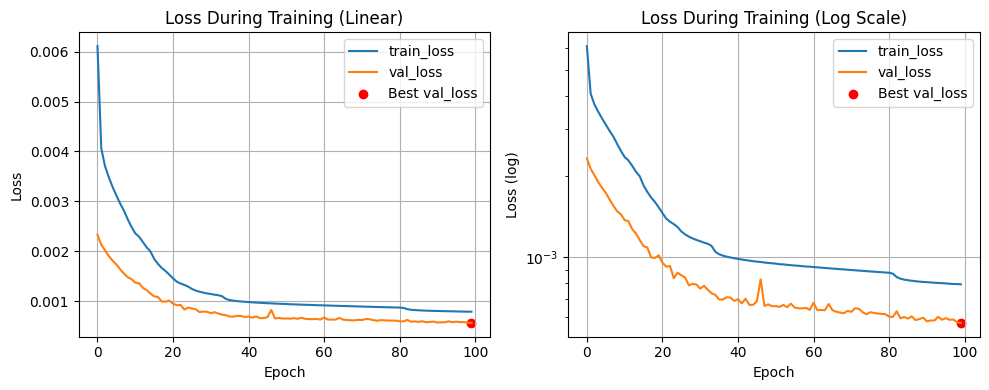

Best epoch: 100, Best val_loss: 0.000571
Loss history saved to train_loss_history.csv


In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100, #90
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save model
model.save('lstm_autoencoder_model3.h5')

# Save loss history to CSV
import pandas as pd
loss_df = pd.DataFrame(history.history)
loss_df.to_csv('train_loss_history.csv', index=False)

# Plot loss (linear and log scale)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss During Training (Linear)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.title('Loss During Training (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.grid(True)

# Mark best epoch
best_epoch = int(np.argmin(history.history['val_loss']))
plt.subplot(1, 2, 1)
plt.scatter(best_epoch, history.history['val_loss'][best_epoch], color='red', label='Best val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(best_epoch, history.history['val_loss'][best_epoch], color='red', label='Best val_loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best epoch: {best_epoch+1}, Best val_loss: {history.history['val_loss'][best_epoch]:.6f}")
print("Loss history saved to train_loss_history.csv")


In [37]:
# Predict test set
X_test_pred = model.predict(X_test)
test_reconstruction_error = np.mean(np.mean(np.square(X_test - X_test_pred), axis=1), axis=1)

# แสดงค่า loss บน test set
test_loss = np.mean(test_reconstruction_error)
print(f"Test Reconstruction Loss: {test_loss}")


706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Test Reconstruction Loss: 0.0005338260476153248


# Test

In [38]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA

df_test = pd.read_csv('../../data/devAll2_prepared.csv')
df_original_features = df_test.copy() 

df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test.sort_values(by='timestamp').reset_index(drop=True)

scaler = joblib.load('scaler3.save')
numerical_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng']

missing_cols = [col for col in numerical_cols if col not in df_test.columns]
if missing_cols:
    raise ValueError(f"Missing columns in input CSV: {missing_cols}")

scaled_values = scaler.transform(df_test[numerical_cols])
for i, col in enumerate(numerical_cols):
    df_test[f'scaled_{col}'] = scaled_values[:, i]

# === sequence for predict ===
SEQUENCE_LENGTH = 30

def create_sequences(df, sequence_length, numerical_cols):
    sequences, device_ids, timestamps = [], [], []
    # เก็บ index เริ่มต้นของแต่ละ sequence เพื่อเชื่อมโยงกับ df_test
    start_indices = []

    for dev_id, group in df.groupby('devID'):
        group = group.sort_values('timestamp')
        values = group[[f'scaled_{col}' for col in numerical_cols]].values
        time_vals = group['timestamp'].values
        
        # เพิ่มคอลัมน์ original_index เพื่อให้สามารถเชื่อมโยงกลับไปยัง df_test ได้
        group = group.reset_index(drop=False).rename(columns={'index': 'original_df_index'})

        for i in range(len(values) - sequence_length + 1):
            sequences.append(values[i:i + sequence_length])
            device_ids.append(dev_id)
            timestamps.append(time_vals[i + sequence_length - 1]) # timestamp ของจุดสุดท้ายใน sequence
            start_indices.append(group['original_df_index'].iloc[i + sequence_length - 1]) # เก็บ original index ของจุดสุดท้าย

    return np.array(sequences), device_ids, timestamps, start_indices

# สร้าง sequence
X_seq_test, device_ids_test, timestamps_test, start_indices_test = create_sequences(df_test, SEQUENCE_LENGTH, numerical_cols)

# === 5. โหลดโมเดลและ predict ===
model = load_model('lstm_autoencoder_model3.h5', compile=False)
X_pred = model.predict(X_seq_test)

# === 6. คำนวณ reconstruction error ===
reconstruction_error = np.mean(np.mean(np.square(X_seq_test - X_pred), axis=1), axis=1)

# === 7. สร้าง DataFrame เก็บผล ===
df_results = pd.DataFrame({
    'devID': device_ids_test,
    'timestamp': timestamps_test,
    'reconstruction_error': reconstruction_error,
    'original_df_index': start_indices_test # เพิ่มคอลัมน์นี้เพื่อ merge กับ df_original_features
})


9411/9411 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step


In [39]:

# === 8. คำนวณ thresholds และกำหนด Anomaly Level ===
threshold_warning = np.percentile(reconstruction_error, 95)
threshold_critical = np.percentile(reconstruction_error, 99)

def classify_anomaly(err):
    if err > threshold_critical:
        return 'critical'
    elif err > threshold_warning:
        return 'warning'
    else:
        return 'normal'

df_results['anomaly_level'] = df_results['reconstruction_error'].apply(classify_anomaly)

print(f"95th percentile (Warning) threshold = {threshold_warning:.5f}")
print(f"99th percentile (Critical) threshold = {threshold_critical:.5f}")
print("\n--- Anomaly Level Counts ---")
print(df_results['anomaly_level'].value_counts())

95th percentile (Warning) threshold = 0.00188
99th percentile (Critical) threshold = 0.00320

--- Anomaly Level Counts ---
anomaly_level
normal      286075
warning      12045
critical      3012
Name: count, dtype: int64


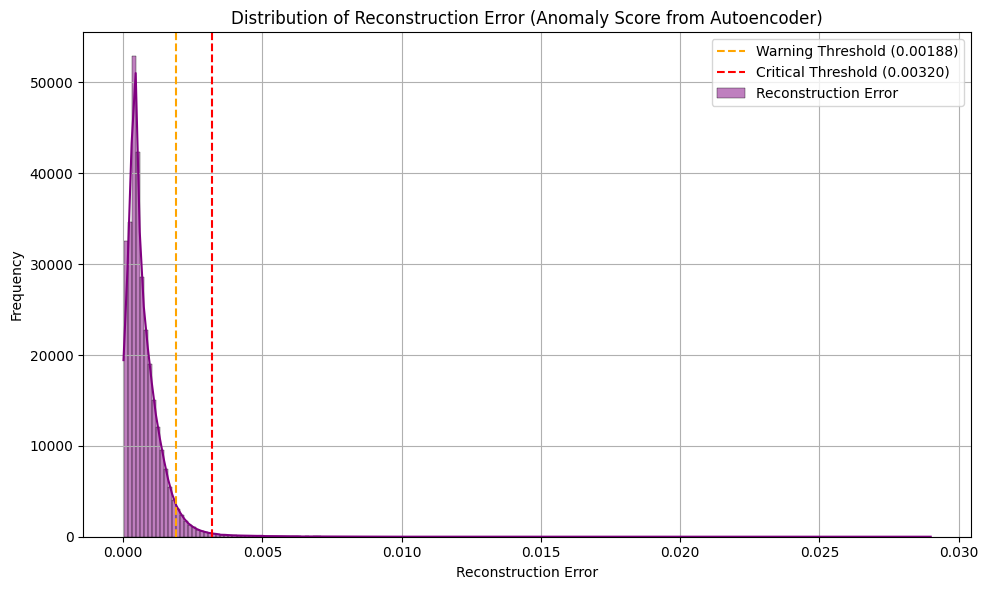

In [40]:
# --- การรวมข้อมูลเพื่อการวิเคราะห์เพิ่มเติม ---
# เราจะ merge df_results กับ df_original_features โดยใช้ 'original_df_index'
# เพื่อให้มีคอลัมน์ features เดิมที่ไม่ถูก scale อยู่ใน DataFrame เดียวกัน
# สร้างคอลัมน์ 'index' ใน df_original_features ให้ตรงกับ 'original_df_index'
# Remove duplicate columns in df_original_features (keep only one 'original_df_index')
df_original_features = df_original_features.loc[:, ~df_original_features.columns.duplicated()]

# Ensure 'original_df_index' exists and is unique
if 'original_df_index' not in df_original_features.columns:
    df_original_features = df_original_features.reset_index().rename(columns={'index': 'original_df_index'})

# Convert timestamp to datetime64[ns] for merge compatibility
df_original_features['timestamp'] = pd.to_datetime(df_original_features['timestamp'])

# Merge ข้อมูล
df_analysis = pd.merge(df_results, df_original_features, on=['devID', 'timestamp', 'original_df_index'], how='left')

# ตรวจสอบว่ามีค่า NaN หลังจาก Merge หรือไม่ (ถ้ามี แสดงว่า timestamp/devID ไม่ตรงกันพอดี)
if df_analysis.isnull().any().any():
    print("\nWarning: Missing values found in merged DataFrame. Ensure timestamps and devIDs match for accurate feature analysis.")

# --- เริ่มการสร้าง Visualization ---
# ตั้งค่า palette สำหรับ Anomaly Levels
palette_anomaly = {'normal': 'green', 'warning': 'orange', 'critical': 'red'}

# --- 1. Distribution of Reconstruction Error ---
plt.figure(figsize=(10, 6))
sns.histplot(df_results['reconstruction_error'], bins=200, kde=True, color='purple', label='Reconstruction Error')
plt.axvline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
plt.axvline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
plt.title('Distribution of Reconstruction Error (Anomaly Score from Autoencoder)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\4259196113.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)


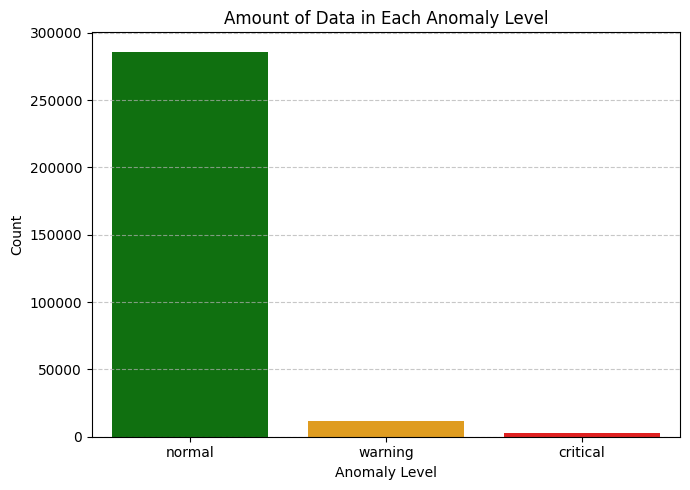

In [41]:
# --- 2. Anomaly Level Counts ---
plt.figure(figsize=(7, 5))
sns.countplot(data=df_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)
plt.title('Amount of Data in Each Anomaly Level')
plt.xlabel('Anomaly Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

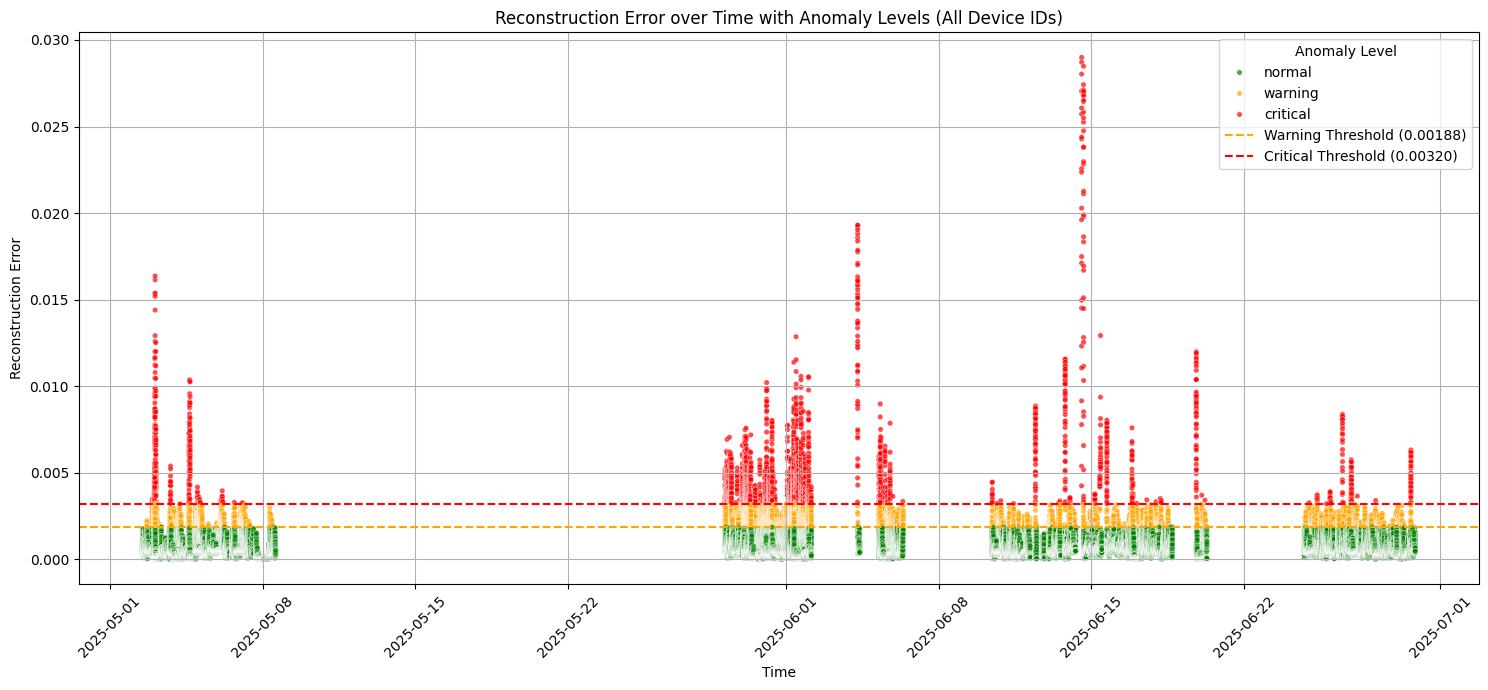

In [42]:
# --- 3. Reconstruction Error Over Time with Anomaly Levels (All Devices) ---
plt.figure(figsize=(15, 7))
sns.scatterplot(
    data=df_results, x='timestamp', y='reconstruction_error',
    hue='anomaly_level', palette=palette_anomaly, alpha=0.7, s=15,
    hue_order=['normal', 'warning', 'critical']
)
plt.axhline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
plt.axhline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
plt.title('Reconstruction Error over Time with Anomaly Levels (All Device IDs)')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.xticks(rotation=45)
plt.legend(title='Anomaly Level')
plt.tight_layout()
plt.grid(True)
plt.show()


C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1664041999.py:8: UserWarning: Glyph 3592 (\N{THAI CHARACTER CHO CHAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1664041999.py:8: UserWarning: Glyph 3635 (\N{THAI CHARACTER SARA AM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1664041999.py:8: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1664041999.py:8: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3592 (\N{THAI CHARACTER CHO CHAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\

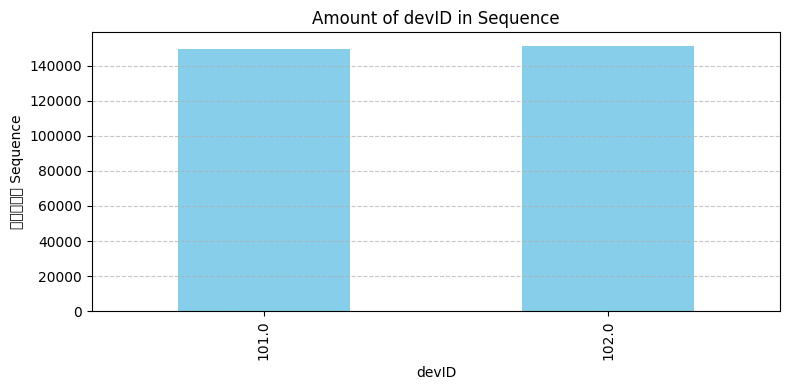

Dynamic 95th percentile (Warning) threshold = 0.00188
Dynamic 99th percentile (Critical) threshold = 0.00320


In [43]:
# --- 5.1. Bar Plot: จำนวนข้อมูลแต่ละ devID ---
plt.figure(figsize=(8, 4))
df_results['devID'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Amount of devID in Sequence')
plt.xlabel('devID')
plt.ylabel('จำนวน Sequence')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 5.2. Dynamic Thresholds (Percentile) ---
threshold_warning = np.percentile(df_results['reconstruction_error'], 95)
threshold_critical = np.percentile(df_results['reconstruction_error'], 99)
print(f"Dynamic 95th percentile (Warning) threshold = {threshold_warning:.5f}")
print(f"Dynamic 99th percentile (Critical) threshold = {threshold_critical:.5f}")



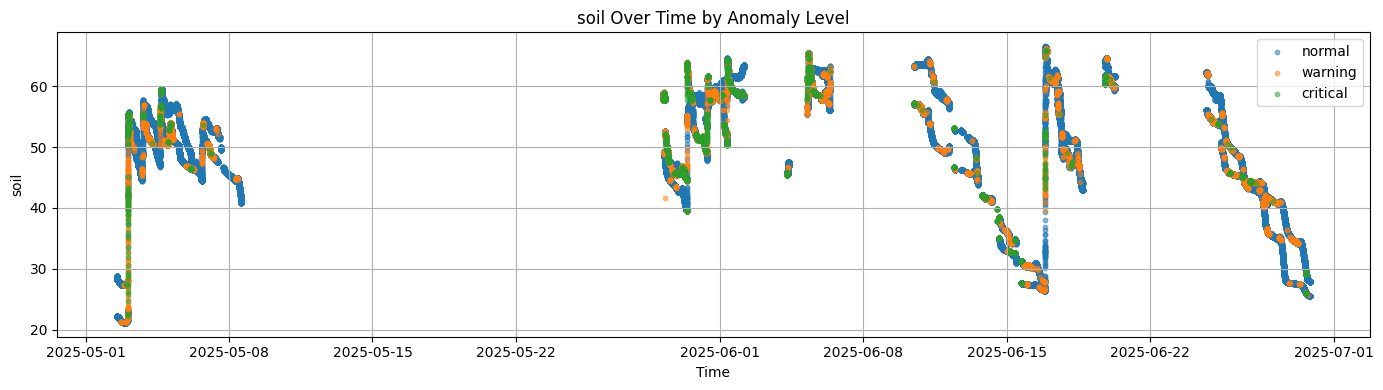

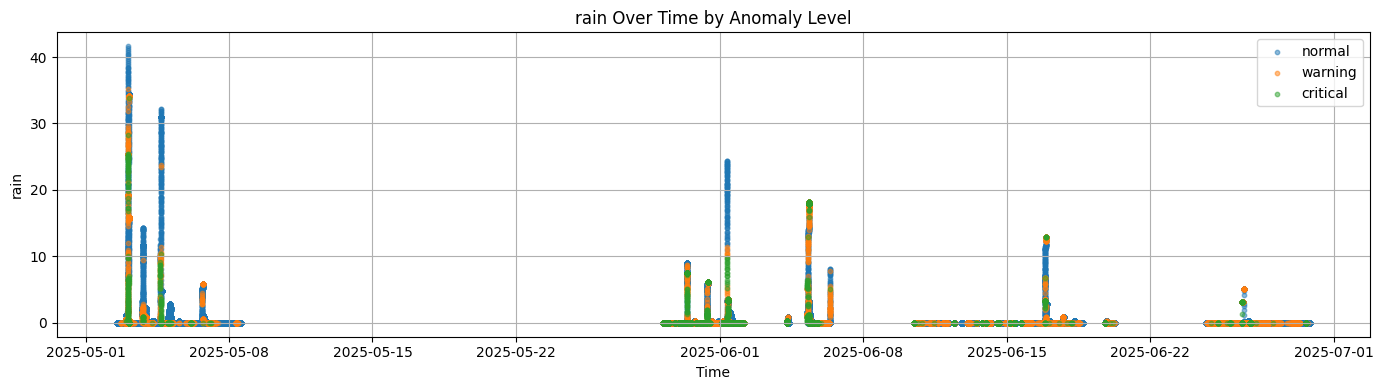

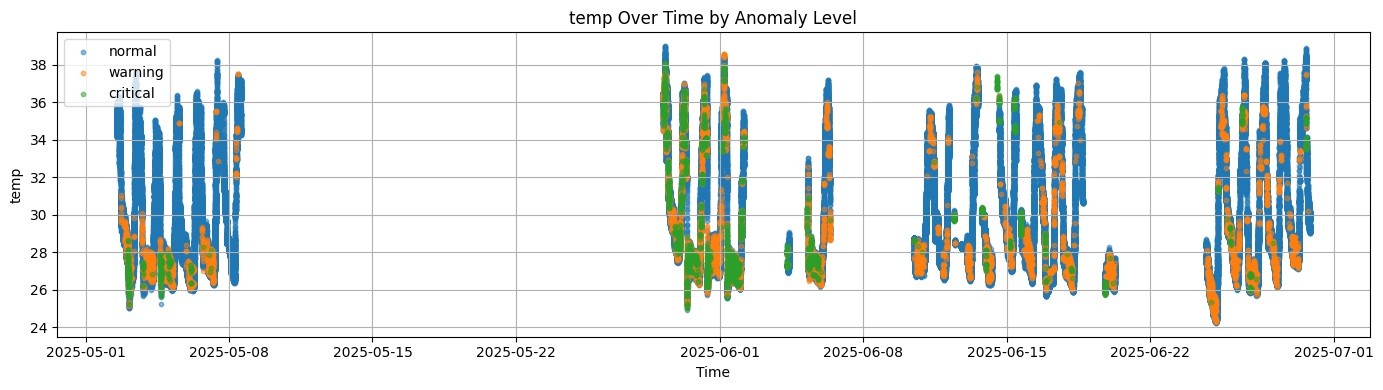

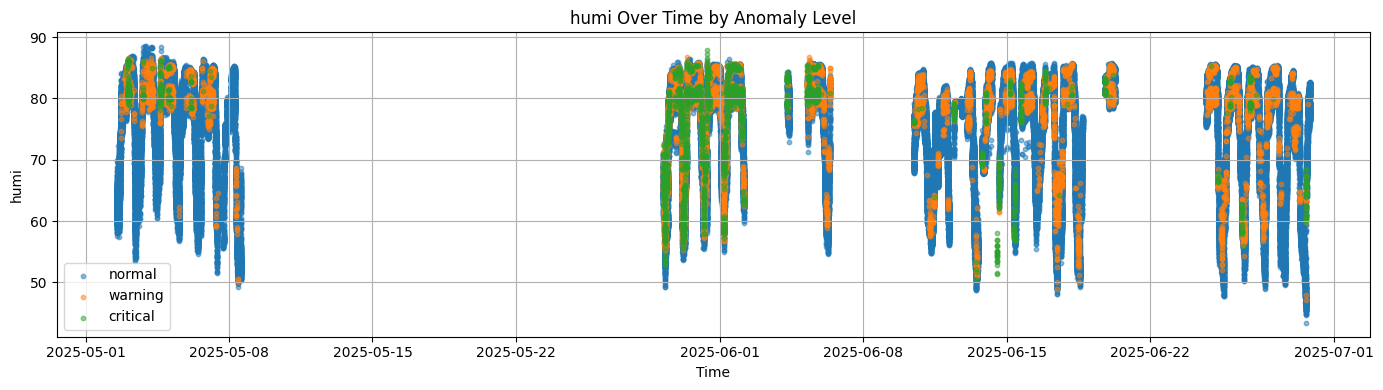

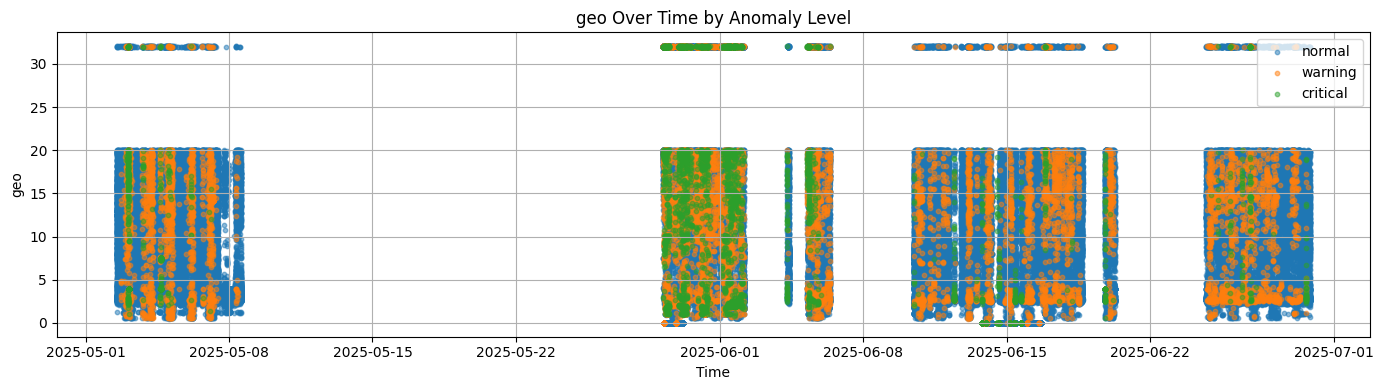

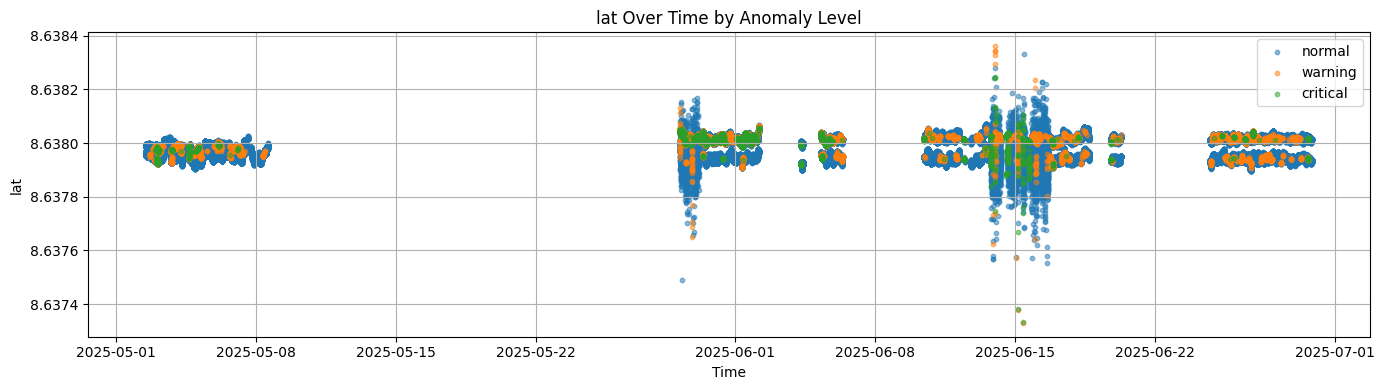

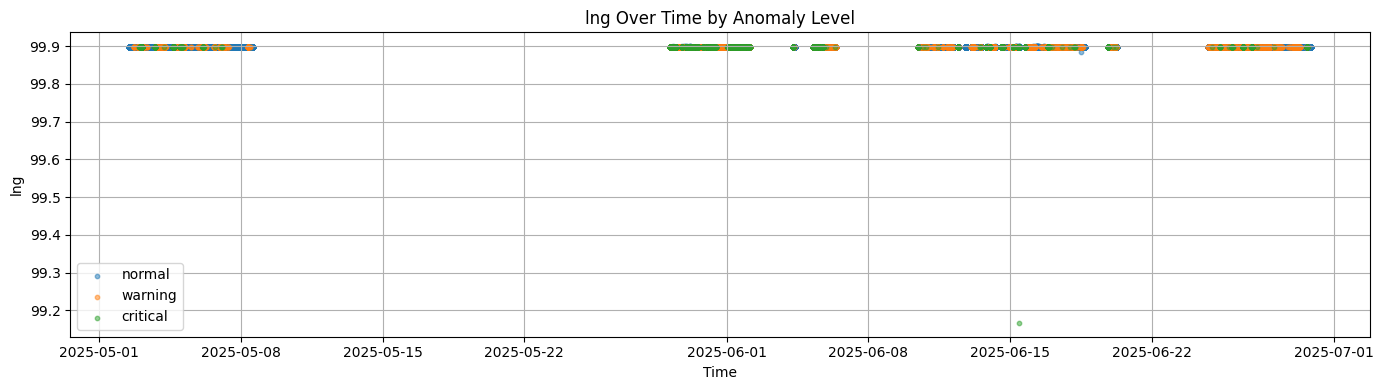

In [44]:
for feature in numerical_cols:
    plt.figure(figsize=(14, 4))
    for level in ['normal', 'warning', 'critical']:
        subset = df_results[df_results['anomaly_level'] == level]
        plt.scatter(subset['timestamp'], df_original_features.loc[subset['original_df_index'], feature],
                    label=level, alpha=0.5, s=10)
    plt.title(f'{feature} Over Time by Anomaly Level')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:34:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


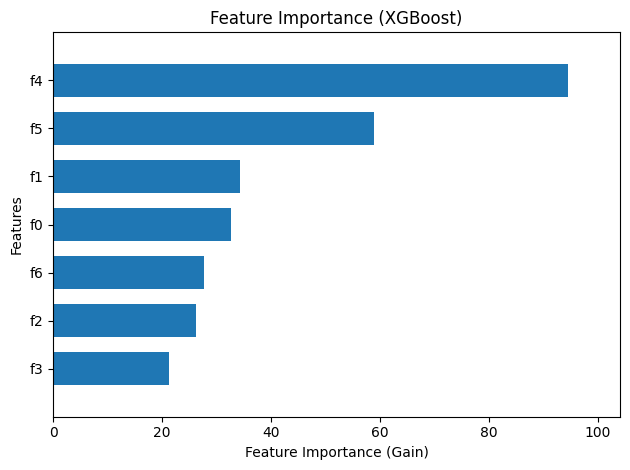

In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# เตรียม features และ label สำหรับ classification
# ตัวอย่าง: ใช้ original features จาก df_original_features ที่ตรงกับ original_df_index ใน df_merged
# และ label anomaly_level เป็น binary (critical=1, อื่นๆ=0)

# เลือกเฉพาะแถวที่มี original_df_index ตรงกัน
df_feat = df_results.merge(df_original_features, on=['original_df_index', 'timestamp', 'devID'], how='left')

# เลือกเฉพาะ features ที่ต้องการ
feature_names = ['soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng']
X_features_last_step = df_feat[feature_names].values

# สร้าง label anomaly (critical=1, อื่นๆ=0)
y_anomaly = (df_feat['anomaly_level'] == 'critical').astype(int).values

# train/val split
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(
    X_features_last_step, y_anomaly, test_size=0.2, random_state=42
)

model_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train_clf, y_train_clf)

# Plot Feature Importance
xgb.plot_importance(model_xgb, importance_type='gain', xlabel='Feature Importance (Gain)', 
                    show_values=False, height=0.7, grid=False, max_num_features=15)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


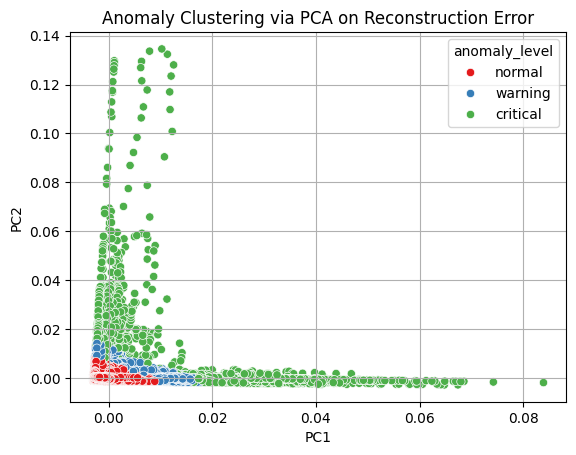

In [46]:
from sklearn.decomposition import PCA
import seaborn as sns

# สร้าง feature จาก reconstruction error
X_error = np.mean((X_seq_test - X_pred)**2, axis=1)  # shape: (num_samples, seq_len)

# ลดมิติด้วย PCA เพื่อ visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_error)

df_viz = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_viz['anomaly_level'] = df_results['anomaly_level']

# วาดกราฟ
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='anomaly_level', palette='Set1')
plt.title("Anomaly Clustering via PCA on Reconstruction Error")
plt.grid(True)
plt.show()



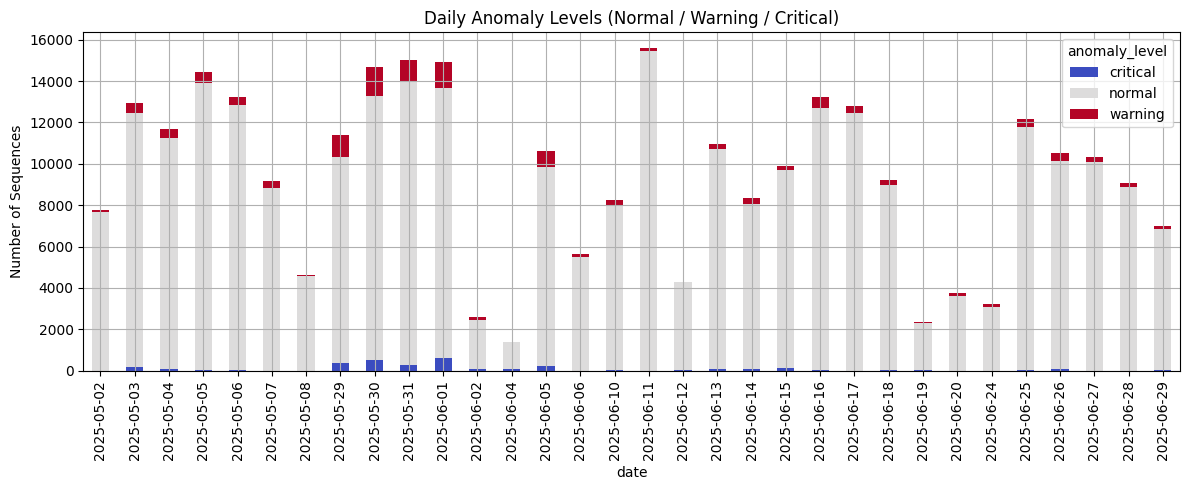

In [47]:
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date
alerts_per_day = df_results.groupby(['date', 'anomaly_level']).size().unstack(fill_value=0)

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12, 5), colormap='coolwarm')
plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.ylabel("Number of Sequences")
plt.grid(True)
plt.tight_layout()
plt.show()


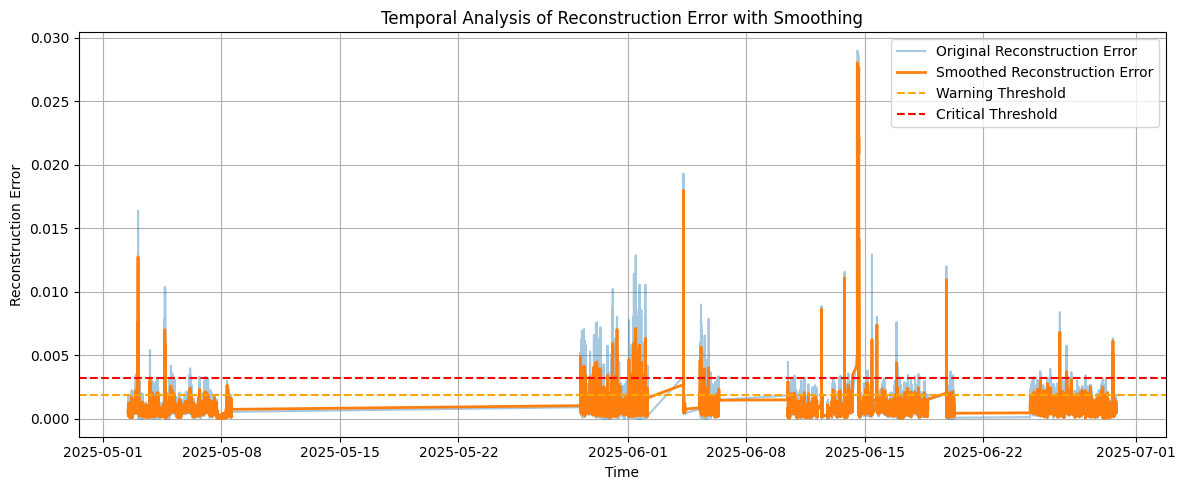

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# สมมติ df_results มีคอลัมน์ timestamp, reconstruction_error, anomaly_level

# Convert timestamp เป็น datetime (ถ้ายังไม่ใช่)
df_results['timestamp'] = pd.to_datetime(df_results['timestamp'])

# Sort ตาม timestamp
df_results = df_results.sort_values('timestamp')

# ทำ rolling mean smoothing (window = 5 sequences)
df_results['reconstruction_error_smooth'] = df_results['reconstruction_error'].rolling(window=5, center=True).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_results['timestamp'], df_results['reconstruction_error'], label='Original Reconstruction Error', alpha=0.4)
plt.plot(df_results['timestamp'], df_results['reconstruction_error_smooth'], label='Smoothed Reconstruction Error', linewidth=2)
plt.axhline(y=threshold_warning, color='orange', linestyle='--', label='Warning Threshold')
plt.axhline(y=threshold_critical, color='red', linestyle='--', label='Critical Threshold')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.title('Temporal Analysis of Reconstruction Error with Smoothing')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
import folium
from folium.plugins import HeatMap

# เตรียมข้อมูลสำหรับ heatmap
heat_data = df_results.merge(df_original_features[['timestamp', 'lat', 'lng']], on='timestamp')
heat_data = heat_data[['lat', 'lng', 'reconstruction_error']].dropna()

# สร้างแผนที่
map_center = [heat_data['lat'].mean(), heat_data['lng'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# สร้าง Heatmap
HeatMap(data=heat_data.values, radius=15).add_to(m)

m.save("anomaly_heatmap.html")


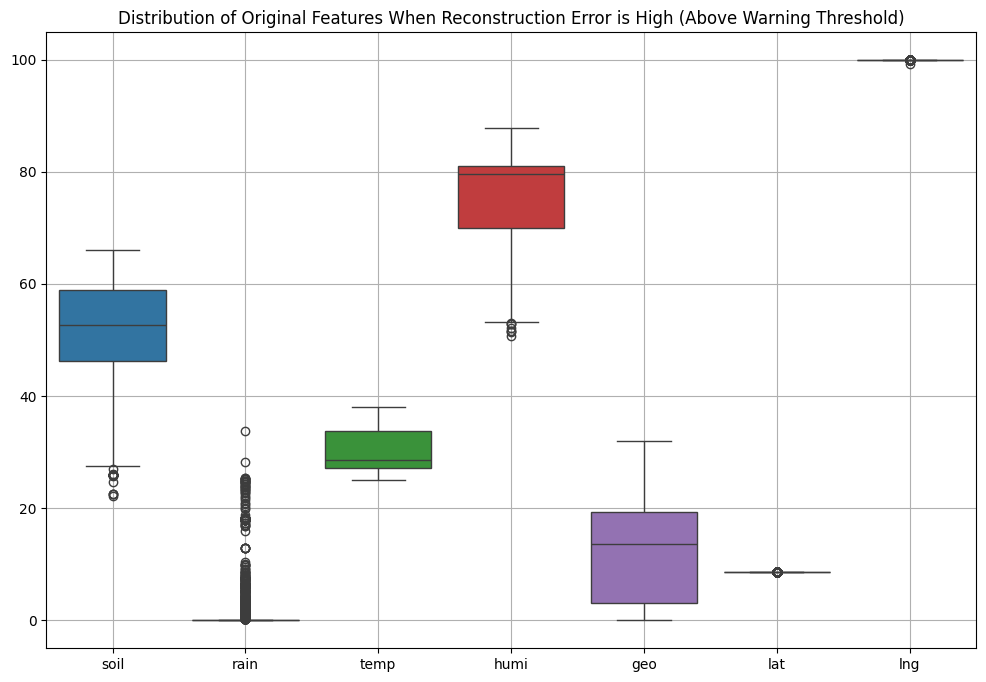

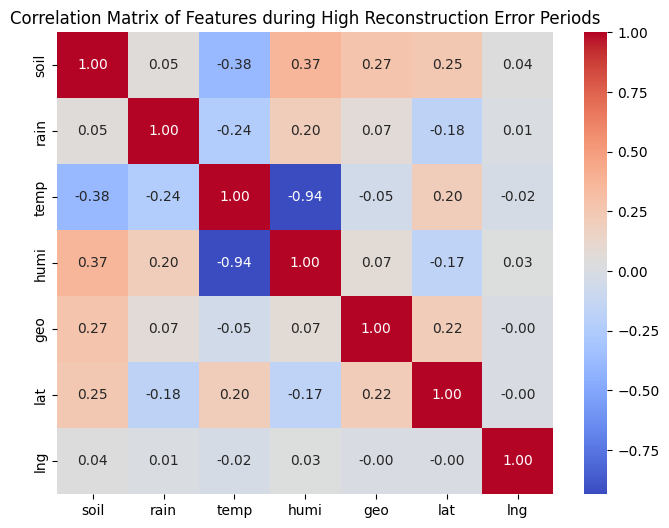

In [50]:
high_error_df = df_analysis[df_analysis['reconstruction_error'] > threshold_critical]

import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(data=high_error_df[numerical_cols])
plt.title('Distribution of Original Features When Reconstruction Error is High (Above Warning Threshold)')
plt.grid(True)
plt.show()

# หรือดู correlation matrix ของ features ในช่วง high_error
corr_matrix = high_error_df[numerical_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features during High Reconstruction Error Periods')
plt.show()


C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1331821430.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long[df_long['feature'] == feature],


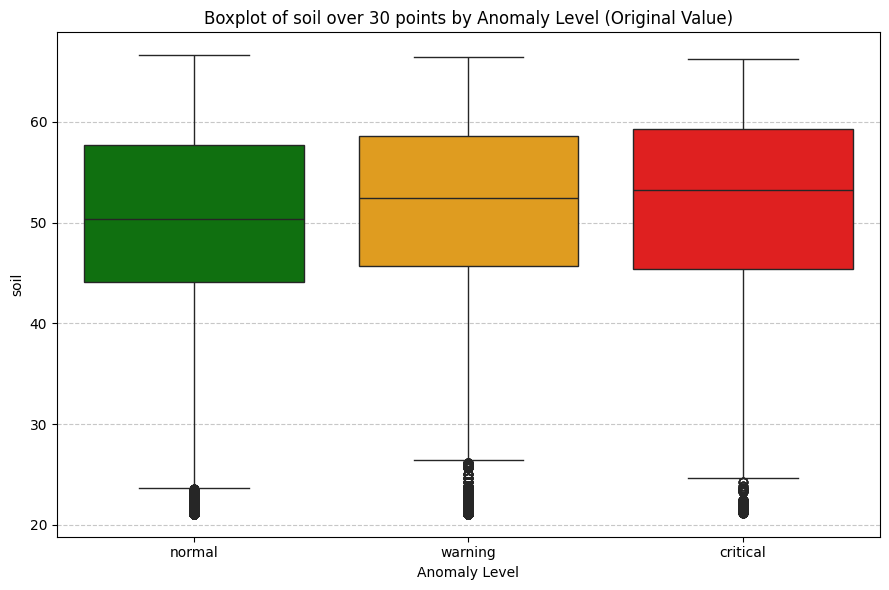

C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1331821430.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long[df_long['feature'] == feature],


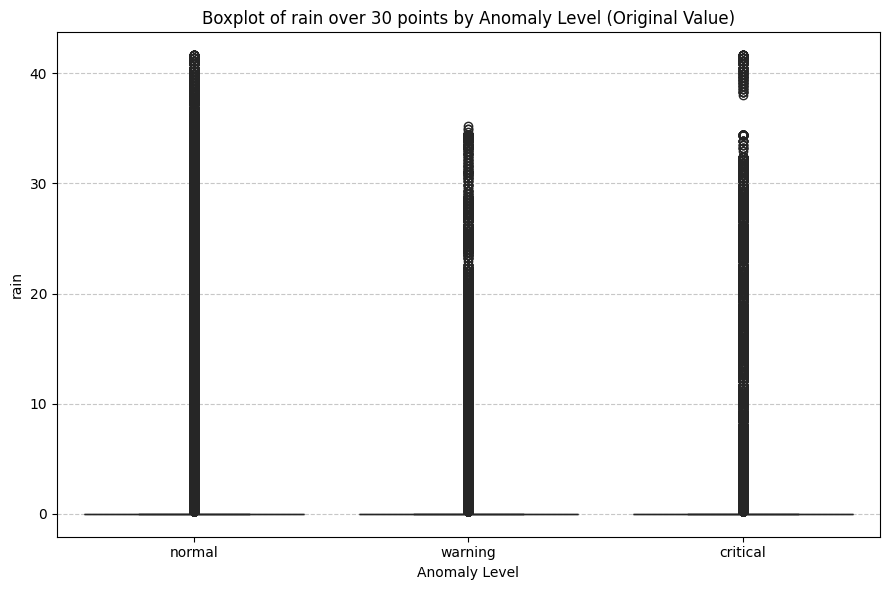

C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1331821430.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long[df_long['feature'] == feature],


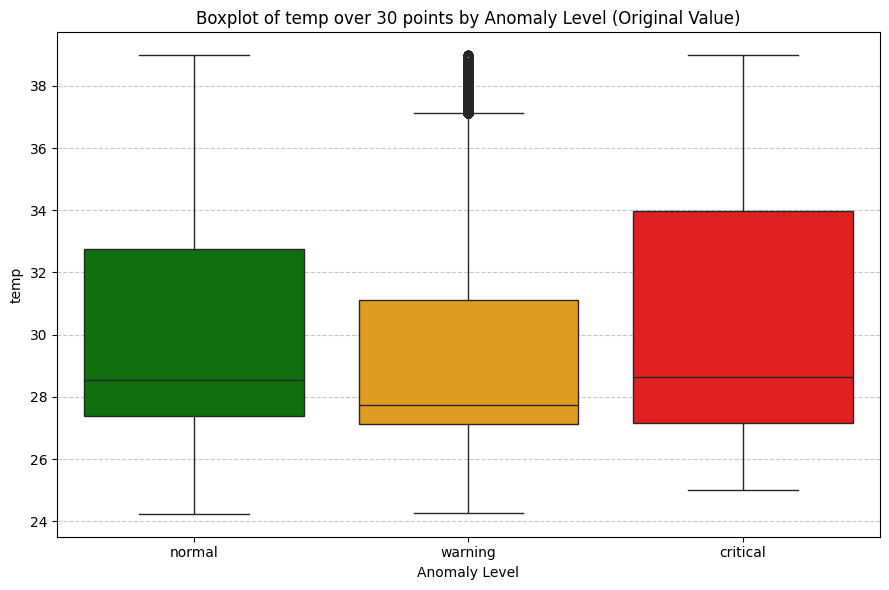

C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1331821430.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long[df_long['feature'] == feature],


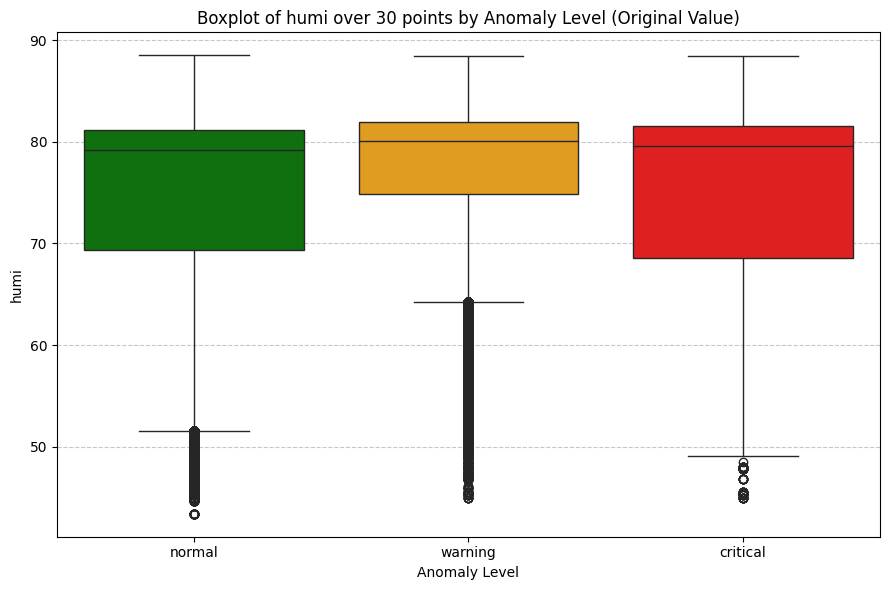

C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1331821430.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long[df_long['feature'] == feature],


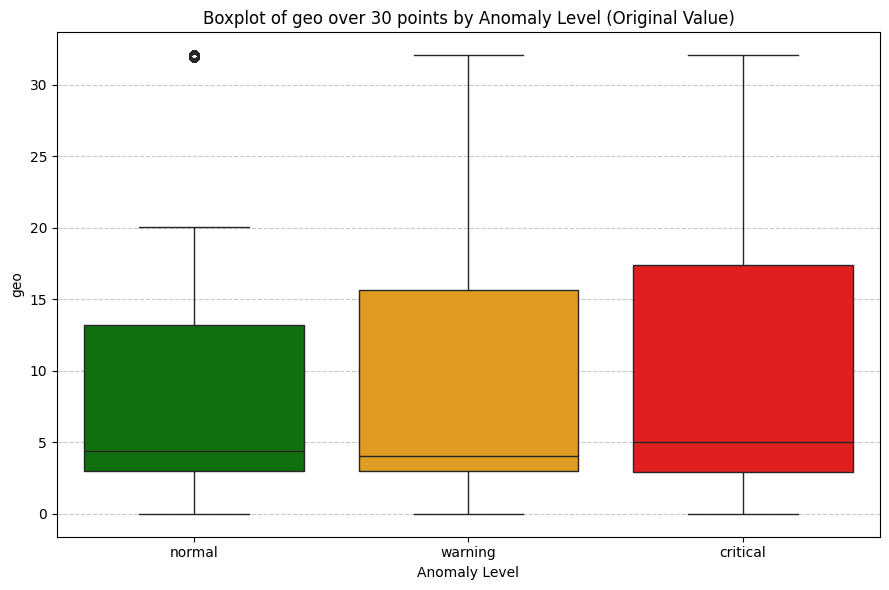

C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1331821430.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long[df_long['feature'] == feature],


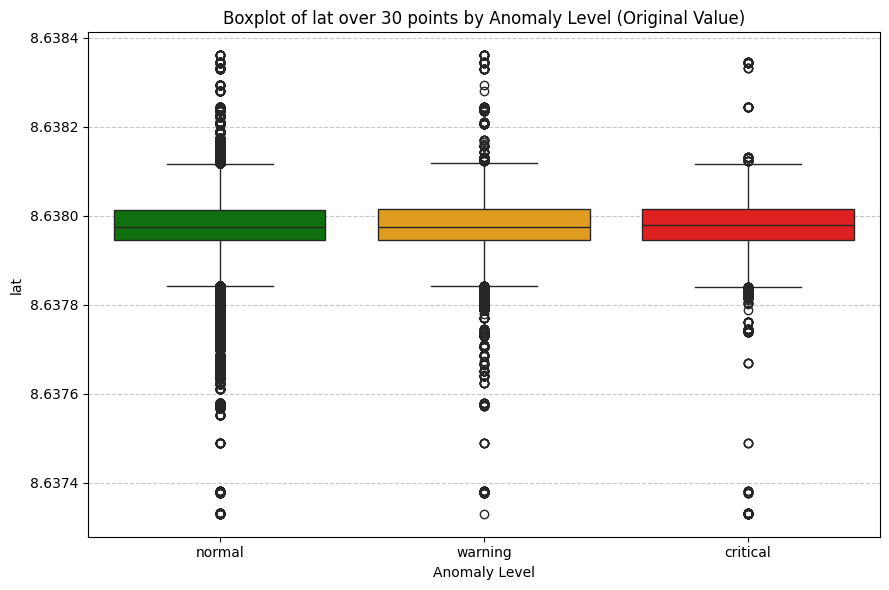

C:\Users\ahmad\AppData\Local\Temp\ipykernel_6140\1331821430.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long[df_long['feature'] == feature],


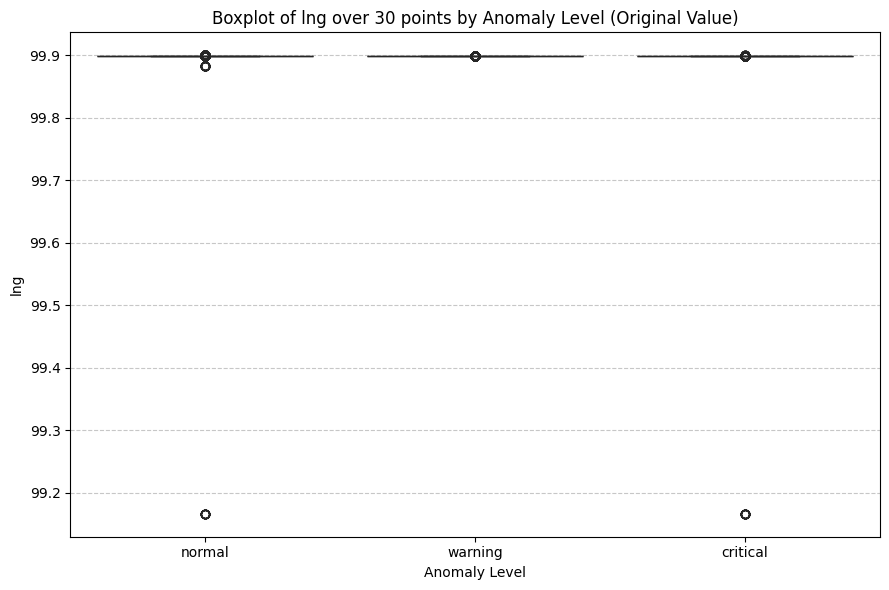

In [51]:
import pandas as pd
import numpy as np

seq_len = SEQUENCE_LENGTH
num_seq = len(X_seq_test)
features = numerical_cols

# เตรียม DataFrame index และข้อมูลล่วงหน้า
all_indices = []
sequence_indices = []
dev_ids = []
anomaly_lvls = []

for seq_idx in range(num_seq):
    last_idx = start_indices_test[seq_idx]
    idx_range = range(last_idx - seq_len + 1, last_idx + 1)
    # กรอง idx ที่ไม่หลุดขอบ
    idx_range = [idx for idx in idx_range if 0 <= idx < len(df_original_features)]

    all_indices.extend(idx_range)
    sequence_indices.extend([seq_idx] * len(idx_range))
    dev_ids.extend([df_results.loc[seq_idx, 'devID']] * len(idx_range))
    anomaly_lvls.extend([df_results.loc[seq_idx, 'anomaly_level']] * len(idx_range))

# รวมข้อมูลจาก df_original_features
df_selected = df_original_features.iloc[all_indices].copy()
df_selected['sequence_index'] = sequence_indices
df_selected['devID'] = dev_ids
df_selected['anomaly_level'] = anomaly_lvls

# แปลง wide → long format
df_long = df_selected.melt(
    id_vars=['sequence_index', 'devID', 'timestamp', 'anomaly_level'],
    value_vars=features,
    var_name='feature',
    value_name='value'
)

import seaborn as sns
import matplotlib.pyplot as plt

for feature in features:
    plt.figure(figsize=(9,6))
    sns.boxplot(data=df_long[df_long['feature'] == feature],
                x='anomaly_level', y='value',
                order=['normal', 'warning', 'critical'],
                palette=palette_anomaly)
    plt.title(f'Boxplot of {feature} over {seq_len} points by Anomaly Level (Original Value)')
    plt.xlabel('Anomaly Level')
    plt.ylabel(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Sumulate in Device

In [52]:
"""
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import collections # สำหรับ deque
import matplotlib.pyplot as plt
import seaborn as sns

scaler = joblib.load('scaler2.save')
model = load_model('lstm_autoencoder_model2.h5', compile=False)

SEQUENCE_LENGTH = 30
numerical_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng']
LAST_N_ROWS = 1000

df_full_data_source = pd.read_csv('../../data/devAll2_prepared.csv')
df_full_data_source['timestamp'] = pd.to_datetime(df_full_data_source['timestamp'])

df_full_data_source = df_full_data_source.sort_values(by=['timestamp']).reset_index(drop=True)

df_stream_data_source = df_full_data_source.tail(LAST_N_ROWS).reset_index(drop=True)

# --- hresholds ---
threshold_warning = 0.01
threshold_critical = 0.02

def classify_anomaly(err):
    if err > threshold_critical:
        return 'critical'
    elif err > threshold_warning:
        return 'warning'
    else:
        return 'normal'
























    print(confusion_matrix(y_true, y_pred))    print(classification_report(y_true, y_pred))    y_pred = (df_results['anomaly_level'] == 'critical').astype(int)    y_true = df_analysis['landslide_event']    from sklearn.metrics import classification_report, confusion_matrixif 'landslide_event' in df_analysis.columns:# ถ้ามี label เหตุการณ์ดินถล่มจริงplt.show()plt.tight_layout()plt.legend()plt.title('Soil Moisture Distribution: Train vs Test')plt.hist(df_analysis.loc[df_results.index[len(X_train):], 'soil'], bins=50, alpha=0.7, label='Test')plt.hist(df_analysis.loc[df_results.index[:len(X_train)], 'soil'], bins=50, alpha=0.7, label='Train')plt.subplot(1,2,2)plt.legend()plt.title('Rain Distribution: Train vs Test')plt.hist(df_analysis.loc[df_results.index[len(X_train):], 'rain'], bins=50, alpha=0.7, label='Test')plt.hist(df_analysis.loc[df_results.index[:len(X_train)], 'rain'], bins=50, alpha=0.7, label='Train')plt.subplot(1,2,1)plt.figure(figsize=(12,5))# วิเคราะห์ distribution ของ rain/soil ใน training set เทียบกับ test set# --- การเตรียมบัฟเฟอร์สำหรับแต่ละ devID ---
device_buffers = {} 
device_results = collections.defaultdict(list) 

print(f"--- Starting Real-time Anomaly Detection Simulation (Last {LAST_N_ROWS} Rows by Timestamp) ---")
print(f"Warning Threshold: {threshold_warning:.5f}")
print(f"Critical Threshold: {threshold_critical:.5f}")
print("-" * 50)

# ลูปผ่านข้อมูลเพื่อจำลองการรับค่าทีละแถว
current_dev_id_processing = None

for index, row in df_stream_data_source.iterrows():
    dev_id = row['devID']
    current_timestamp = row['timestamp']
    current_features = row[numerical_cols].values 
    
    if dev_id not in device_buffers:
        device_buffers[dev_id] = collections.deque(maxlen=SEQUENCE_LENGTH)

    scaled_features = scaler.transform(current_features.reshape(1, -1))[0]
    
    device_buffers[dev_id].append(scaled_features)
    
    if len(device_buffers[dev_id]) == SEQUENCE_LENGTH:
        input_sequence = np.array(device_buffers[dev_id]).reshape(1, SEQUENCE_LENGTH, len(numerical_cols))

        predicted_sequence = model.predict(input_sequence, verbose=0)

        error = np.mean(np.mean(np.square(input_sequence - predicted_sequence), axis=1), axis=1)[0]

        anomaly_level = classify_anomaly(error)

        print(f"  DevID: {dev_id}, Time: {current_timestamp}, Error: {error:.6f}, Level: {anomaly_level.upper()}")

        device_results['devID'].append(dev_id)
        device_results['timestamp'].append(current_timestamp)
        device_results['reconstruction_error'].append(error)
        device_results['anomaly_level'].append(anomaly_level)

        for col in numerical_cols:
            if col not in device_results:
                device_results[col] = []
            device_results[col].append(row[col])

print("\n--- Real-time Anomaly Detection Simulation Complete ---")

df_realtime_results = pd.DataFrame(device_results)

# --- การพลอตผลลัพธ์ (ถ้ามีข้อมูล) ---
if not df_realtime_results.empty:
    print("\n--- Summary of Real-time Anomaly Detection Results ---")
    print(df_realtime_results['anomaly_level'].value_counts())

    palette_anomaly = {'normal': 'green', 'warning': 'orange', 'critical': 'red'}

    # 1. Distribution of Reconstruction Error (Real-time)
    plt.figure(figsize=(10, 6))
    sns.histplot(df_realtime_results['reconstruction_error'], bins=50, kde=True, color='purple', label='Reconstruction Error')
    plt.axvline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
    plt.axvline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
    plt.title('Distribution of Reconstruction Error (Real-time Simulation - Last 1000 Rows)')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Anomaly Level Counts (Real-time)
    plt.figure(figsize=(7, 5))
    sns.countplot(data=df_realtime_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)
    plt.title('Amount of Data in Each Anomaly Level (Real-time Simulation - Last 1000 Rows)')
    plt.xlabel('Anomaly Level')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 3. Reconstruction Error Over Time with Anomaly Levels (Real-time)
    plt.figure(figsize=(15, 7))
    sns.scatterplot(
        data=df_realtime_results, x='timestamp', y='reconstruction_error',
        hue='devID', # เปลี่ยนเป็น hue='devID' เพื่อดูแยกแต่ละอุปกรณ์
        palette='tab10', # ใช้ palette ที่มีสีหลากหลายสำหรับ devID
        alpha=0.7, s=15,
        style='anomaly_level', # เพิ่ม style เพื่อแยกระดับ Anomaly
        markers={'normal': 'o', 'warning': '^', 'critical': 'X'}, # กำหนดรูปร่าง marker
        hue_order=sorted(df_realtime_results['devID'].unique()) # เรียง devID ใน legend
    )
    plt.axhline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
    plt.axhline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
    plt.title('Reconstruction Error over Time by Device ID (Real-time Simulation - Last 1000 Rows)')
    plt.xlabel('Time')
    plt.ylabel('Reconstruction Error')
    plt.xticks(rotation=45)
    plt.legend(title='Device ID / Anomaly Level', bbox_to_anchor=(1.05, 1), loc='upper left') # ขยับ legend
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # 4. Box Plot of Original Features by Anomaly Level (Real-time)
    print("\n--- Box Plots of Original Features by Anomaly Level (Real-time Simulation - Last 1000 Rows) ---")
    for feature in numerical_cols:
        plt.figure(figsize=(9, 6))
        sns.boxplot(data=df_realtime_results, x='anomaly_level', y=feature,
                    order=['normal', 'warning', 'critical'], palette=palette_anomaly)
        plt.title(f'Boxplot of {feature} by Anomaly Level (Real-time Simulation - Last 1000 Rows)', fontsize=14)
        plt.xlabel('Anomaly Level', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    print("\nAll Box Plots for Original Features successfully created!")

else:
    print("\nNo anomaly detection results were generated for the last 1000 rows. Check data availability and SEQUENCE_LENGTH.")
    
    """

'\nimport pandas as pd\nimport numpy as np\nimport joblib\nfrom tensorflow.keras.models import load_model\nimport collections # สำหรับ deque\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nscaler = joblib.load(\'scaler2.save\')\nmodel = load_model(\'lstm_autoencoder_model2.h5\', compile=False)\n\nSEQUENCE_LENGTH = 30\nnumerical_cols = [\'soil\', \'rain\', \'temp\', \'humi\', \'geo\', \'lat\', \'lng\']\nLAST_N_ROWS = 1000\n\ndf_full_data_source = pd.read_csv(\'../../data/devAll2_prepared.csv\')\ndf_full_data_source[\'timestamp\'] = pd.to_datetime(df_full_data_source[\'timestamp\'])\n\ndf_full_data_source = df_full_data_source.sort_values(by=[\'timestamp\']).reset_index(drop=True)\n\ndf_stream_data_source = df_full_data_source.tail(LAST_N_ROWS).reset_index(drop=True)\n\n# --- hresholds ---\nthreshold_warning = 0.01\nthreshold_critical = 0.02\n\ndef classify_anomaly(err):\n    if err > threshold_critical:\n        return \'critical\'\n    elif err > threshold_warning:\n        